### Importing Libraries

In [2]:
import requests
import json
from pandas.io.json import json_normalize
import pandas as pd

#datavisualizations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point, Polygon
import statsmodels.api as sm

#requests_cache to cache API call data
import requests_cache 
import time
from IPython.core.display import clear_output


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
# keeping data from API calls into cache
requests_cache.install_cache()

### API Calls

While Loop over api.spacexdata (great API !) - over launch pages

Append list with API call results, to then make a DataFrame out of it
All calls cached locally with requests_cache : limit amount of calls needed and ease on the API server

In [6]:
page = 1
final_page = 110 #final page for while loop

responses_list = []

#loop over page with url launches/page
while page < final_page:
    print('The rocket is on the launch pad - API call ignition')
    print(f'SpaceX API call - requesting page {page}/{page}')
    
    # clear the output of each print to make things neater
    clear_output(wait = True)
    
    payload = {'limit':500,
    'page':page}
    url = f'https://api.spacexdata.com/v3/launches/{page}'
    
    response = requests.get(url)
    
    #back stop if error = stop looping
    if response.status_code != 200:
        print('limit page result reached on page number',page,response.text, '- end of API call')
        break
    
    #if it's not a cached result, sleep
    if not getattr(response, 'from_cache', False):
        time.sleep(0.35)
    
    #append response list
    responses_list.append(response)
    
    #increment page number
    page += 1
    
    print("Requested page {}/{}".format(page, page), 'SpaceX API call completed')

limit page result reached on page number 107 {"error":"Not Found"} - end of API call


###### testing API call on 1st launch

In [7]:
url = 'https://api.spacexdata.com/v3/launches/'

result = requests.get(f'https://api.spacexdata.com/v3/launches/1')

print(json.dumps(result.json(), indent=4))

{
    "flight_number": 1,
    "mission_name": "FalconSat",
    "mission_id": [],
    "upcoming": false,
    "launch_year": "2006",
    "launch_date_unix": 1143239400,
    "launch_date_utc": "2006-03-24T22:30:00.000Z",
    "launch_date_local": "2006-03-25T10:30:00+12:00",
    "is_tentative": false,
    "tentative_max_precision": "hour",
    "tbd": false,
    "launch_window": 0,
    "rocket": {
        "rocket_id": "falcon1",
        "rocket_name": "Falcon 1",
        "rocket_type": "Merlin A",
        "first_stage": {
            "cores": [
                {
                    "core_serial": "Merlin1A",
                    "flight": 1,
                    "block": null,
                    "gridfins": false,
                    "legs": false,
                    "reused": false,
                    "land_success": null,
                    "landing_intent": false,
                    "landing_type": null,
                    "landing_vehicle": null
                }
            ]
     

dict of dictionaries

Nested dictionaries & nested lists among columns for 1st stage & 2nd stage of the rocket

- Series 'rocket' encompass key data : first stage & second stage payload data
looping with list to merge data to main df

In [8]:
#dummy df of JSON call & normalize JSON to picture final df result
r0 = responses_list[0]
r0_json = json_normalize(r0.json())
df1 = pd.DataFrame(r0_json)
df1.head()

,flight_number,mission_name,mission_id,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,ships,launch_success,details,static_fire_date_utc,static_fire_date_unix,crew,rocket.rocket_id,rocket.rocket_name,rocket.rocket_type,rocket.first_stage.cores,rocket.second_stage.block,rocket.second_stage.payloads,rocket.fairings.reused,rocket.fairings.recovery_attempt,rocket.fairings.recovered,rocket.fairings.ship,telemetry.flight_club,launch_site.site_id,launch_site.site_name,launch_site.site_name_long,launch_failure_details.time,launch_failure_details.altitude,launch_failure_details.reason,links.mission_patch,links.mission_patch_small,links.reddit_campaign,links.reddit_launch,links.reddit_recovery,links.reddit_media,links.presskit,links.article_link,links.wikipedia,links.video_link,links.youtube_id,links.flickr_images,timeline.webcast_liftoff
0,1,FalconSat,[],False,2006,1143239400,2006-03-24T22:30:00.000Z,2006-03-25T10:30:00+12:00,False,hour,False,0,[],False,Engine failure at 33 seconds and loss of vehicle,2006-03-17T00:00:00.000Z,1142553600,None,falcon1,Falcon 1,Merlin A,"[{'core_serial': 'Merlin1A', 'flight': 1, 'blo...",1,"[{'payload_id': 'FalconSAT-2', 'norad_id': [],...",False,False,False,None,None,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,33,None,merlin engine failure,https://images2.imgbox.com/40/e3/GypSkayF_o.png,https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,None,None,None,None,None,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,[],54


In [9]:
df1.columns

Index(['flight_number', 'mission_name', 'mission_id', 'upcoming',
       'launch_year', 'launch_date_unix', 'launch_date_utc',
       'launch_date_local', 'is_tentative', 'tentative_max_precision', 'tbd',
       'launch_window', 'ships', 'launch_success', 'details',
       'static_fire_date_utc', 'static_fire_date_unix', 'crew',
       'rocket.rocket_id', 'rocket.rocket_name', 'rocket.rocket_type',
       'rocket.first_stage.cores', 'rocket.second_stage.block',
       'rocket.second_stage.payloads', 'rocket.fairings.reused',
       'rocket.fairings.recovery_attempt', 'rocket.fairings.recovered',
       'rocket.fairings.ship', 'telemetry.flight_club', 'launch_site.site_id',
       'launch_site.site_name', 'launch_site.site_name_long',
       'launch_failure_details.time', 'launch_failure_details.altitude',
       'launch_failure_details.reason', 'links.mission_patch',
       'links.mission_patch_small', 'links.reddit_campaign',
       'links.reddit_launch', 'links.reddit_recovery', 'lin

### Listing variables

**Important variables to keep**

- 'launch_year' : deprecated 
- 'launch_date_unix' : 
- 'launch_date_utc', :
- - 'crew', : 
- 'ships' : 
- 'launch_success' : True when success
- 'details', : 
- 'launch_site.site_id', : 
- 'launch_site.site_name' : 
- 'launch_site.site_name_long', : 
- 'launch_failure_details.time' : 
- 'launch_failure_details.altitude', : 
- 'launch_failure_details.reason' : 

**ID related**
- flight_number : 
- mission_name : 
- mission_id : 

**Launch related**
- launch_year : deprecated 
- launch_date_unix : 
- launch_date_utc :
- - crew : 
- ships : 
- launch_success : True when success
- details : 
- launch_site.site_id : 
- launch_site.site_name : 
- launch_site.site_name_long : 
- launch_failure_details.time : 
- launch_failure_details.altitude : 
- launch_failure_details.reason : 

**Rocket related**
- rocket.rocket_id : 
- rocket.rocket_name : 
- rocket.rocket_type :
- rocket.second_stage.payloads : 
- rocket.fairings.reused : 
- rocket.fairings.recovery_attempt : 
- rocket.fairings.recovered : 

**Useless**
- ditching all links columns = only article & PNG links
- upcoming' : Set as true until the moment of launch

### Flatenning data from API call

- Exploring API data through different nested dictionaries
- creating datafarme with only nested data unfold in columns
- df with 600 columns ! many NaNs, keeping only relevant columns

Function to flatten out JSON call of different nested levels

In [10]:
def flatten_json(y):
    out = {}
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x
    flatten(y)
    return out

In [11]:
#GOOD FLATTENING !

In [12]:
#empty list to append all API calls
temp_frame = [] 
for i in range(len(responses_list)):
    r = responses_list[i]    
    flat = flatten_json(r.json())
    temp_frame.append(flat)
    flatten_df = pd.DataFrame(temp_frame)
flatten_df

,flight_number,mission_name,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_land_success,rocket_first_stage_cores_0_landing_intent,rocket_first_stage_cores_0_landing_type,rocket_first_stage_cores_0_landing_vehicle,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_longitude,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_lifespan_years,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,rocket_fairings_reused,rocket_fairings_recovery_attempt,rocket_fairings_recovered,rocket_fairings_ship,telemetry_flight_club,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,launch_failure_details_time,launch_failure_details_altitude,launch_failure_details_reason,links_mission_patch,links_mission_patch_small,links_reddit_campaign,links_reddit_launch,links_reddit_recovery,links_reddit_media,links_presskit,links_article_link,links_wikipedia,links_video_link,links_youtube_id,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,crew,rocket_second_stage_payloads_1_payload_id,rocket_second_stage_payloads_1_reused,rocket_second_stage_payloads_1_customers_0,rocket_second_stage_payloads_1_nationality,rocket_second_stage_payloads_1_manufacturer,rocket_second_stage_payloads_1_payload_type,rocket_second_stage_payloads_1_payload_mass_kg,rocket_second_stage_payloads_1_payload_mass_lbs,rocket_second_stage_payloads_1_orbit,rocket_second_stage_payloads_1_orbit_params_reference_system,rocket_second_stage_payloads_1_orbit_params_regime,rocket_second_stage_payloads_1_orbit_params_longitude,rocket_second_stage_payloads_1_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_1_orbit_params_eccentricity,rocket_second_stage_payloads_1_orbit_params_periapsis_km,rocket_second_stage_payloads_1_orbit_params_apoapsis_km,rocket_second_stage_payloads_1_orbit_params_inclination_deg,rocket_second_stage_payloads_1_orbit_params_period_min,rocket_second_stage_payloads_1_orbit_params_lifespan_years,rocket_second_stage_payloads_1_orbit_params_epoch,rocket_second_stage_payloads_1_orbit_params_mean_motion,rocket_second_stage_payloads_1_orbit_params_raan,rocket_second_stage_payloads_1_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_1_orbit_params_mean_anomaly,rocket_second_stage_payloads_0_norad_id_0,mission_id_0,rocket_fairings,timeline_go_for_prop_loading,timeline_rp1_loading,timeline_stage1_lox_loading,timeline_stage2_lox_loading,timeline_engine_chill,timeline_prelaunch_checks,timeline_propellant_pressurization,timeline_go_for_launch,timeline_ignition,timeline_liftoff,timeline_maxq,

In [13]:
flatten_df.tail(10)

,flight_number,mission_name,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_land_success,rocket_first_stage_cores_0_landing_intent,rocket_first_stage_cores_0_landing_type,rocket_first_stage_cores_0_landing_vehicle,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_longitude,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_lifespan_years,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,rocket_fairings_reused,rocket_fairings_recovery_attempt,rocket_fairings_recovered,rocket_fairings_ship,telemetry_flight_club,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,launch_failure_details_time,launch_failure_details_altitude,launch_failure_details_reason,links_mission_patch,links_mission_patch_small,links_reddit_campaign,links_reddit_launch,links_reddit_recovery,links_reddit_media,links_presskit,links_article_link,links_wikipedia,links_video_link,links_youtube_id,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,crew,rocket_second_stage_payloads_1_payload_id,rocket_second_stage_payloads_1_reused,rocket_second_stage_payloads_1_customers_0,rocket_second_stage_payloads_1_nationality,rocket_second_stage_payloads_1_manufacturer,rocket_second_stage_payloads_1_payload_type,rocket_second_stage_payloads_1_payload_mass_kg,rocket_second_stage_payloads_1_payload_mass_lbs,rocket_second_stage_payloads_1_orbit,rocket_second_stage_payloads_1_orbit_params_reference_system,rocket_second_stage_payloads_1_orbit_params_regime,rocket_second_stage_payloads_1_orbit_params_longitude,rocket_second_stage_payloads_1_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_1_orbit_params_eccentricity,rocket_second_stage_payloads_1_orbit_params_periapsis_km,rocket_second_stage_payloads_1_orbit_params_apoapsis_km,rocket_second_stage_payloads_1_orbit_params_inclination_deg,rocket_second_stage_payloads_1_orbit_params_period_min,rocket_second_stage_payloads_1_orbit_params_lifespan_years,rocket_second_stage_payloads_1_orbit_params_epoch,rocket_second_stage_payloads_1_orbit_params_mean_motion,rocket_second_stage_payloads_1_orbit_params_raan,rocket_second_stage_payloads_1_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_1_orbit_params_mean_anomaly,rocket_second_stage_payloads_0_norad_id_0,mission_id_0,rocket_fairings,timeline_go_for_prop_loading,timeline_rp1_loading,timeline_stage1_lox_loading,timeline_stage2_lox_loading,timeline_engine_chill,timeline_prelaunch_checks,timeline_propellant_pressurization,timeline_go_for_launch,timeline_ignition,timeline_liftoff,timeline_maxq,

In [14]:
flatten_df.columns

Index(['flight_number', 'mission_name', 'upcoming', 'launch_year',
       'launch_date_unix', 'launch_date_utc', 'launch_date_local',
       'is_tentative', 'tentative_max_precision', 'tbd',
       ...
       'rocket_second_stage_payloads_15_orbit_params_mean_anomaly',
       'timeline_seco-3', 'timeline_seco-4', 'last_date_update',
       'last_ll_launch_date', 'last_ll_update', 'last_wiki_launch_date',
       'last_wiki_revision', 'last_wiki_update', 'launch_date_source'],
      dtype='object', length=615)

In [15]:
# flatten_df.drop(columns=links,axis=1)

In [16]:
#listing all empty columns
percent_missing = flatten_df.isnull().sum() / len(flatten_df) * 100

percent_missing.sort_values().head(60)

flight_number                                                     0.000000
launch_site_site_name_long                                        0.000000
rocket_second_stage_payloads_0_orbit                              0.000000
rocket_second_stage_payloads_0_payload_type                       0.000000
rocket_second_stage_payloads_0_nationality                        0.000000
rocket_second_stage_payloads_0_customers_0                        0.000000
rocket_second_stage_payloads_0_reused                             0.000000
rocket_second_stage_payloads_0_payload_id                         0.000000
launch_site_site_name                                             0.000000
rocket_rocket_type                                                0.000000
rocket_rocket_name                                                0.000000
launch_site_site_id                                               0.000000
launch_date_unix                                                  0.000000
tbd                      

In [17]:
#dropping all columns that starts with 'links'
flatten_df[flatten_df.columns.drop(list(flatten_df.filter(regex='links')))]

,flight_number,mission_name,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_land_success,rocket_first_stage_cores_0_landing_intent,rocket_first_stage_cores_0_landing_type,rocket_first_stage_cores_0_landing_vehicle,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_longitude,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_lifespan_years,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,rocket_fairings_reused,rocket_fairings_recovery_attempt,rocket_fairings_recovered,rocket_fairings_ship,telemetry_flight_club,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,launch_failure_details_time,launch_failure_details_altitude,launch_failure_details_reason,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,crew,rocket_second_stage_payloads_1_payload_id,rocket_second_stage_payloads_1_reused,rocket_second_stage_payloads_1_customers_0,rocket_second_stage_payloads_1_nationality,rocket_second_stage_payloads_1_manufacturer,rocket_second_stage_payloads_1_payload_type,rocket_second_stage_payloads_1_payload_mass_kg,rocket_second_stage_payloads_1_payload_mass_lbs,rocket_second_stage_payloads_1_orbit,rocket_second_stage_payloads_1_orbit_params_reference_system,rocket_second_stage_payloads_1_orbit_params_regime,rocket_second_stage_payloads_1_orbit_params_longitude,rocket_second_stage_payloads_1_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_1_orbit_params_eccentricity,rocket_second_stage_payloads_1_orbit_params_periapsis_km,rocket_second_stage_payloads_1_orbit_params_apoapsis_km,rocket_second_stage_payloads_1_orbit_params_inclination_deg,rocket_second_stage_payloads_1_orbit_params_period_min,rocket_second_stage_payloads_1_orbit_params_lifespan_years,rocket_second_stage_payloads_1_orbit_params_epoch,rocket_second_stage_payloads_1_orbit_params_mean_motion,rocket_second_stage_payloads_1_orbit_params_raan,rocket_second_stage_payloads_1_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_1_orbit_params_mean_anomaly,rocket_second_stage_payloads_0_norad_id_0,mission_id_0,rocket_fairings,timeline_go_for_prop_loading,timeline_rp1_loading,timeline_stage1_lox_loading,timeline_stage2_lox_loading,timeline_engine_chill,timeline_prelaunch_checks,timeline_propellant_pressurization,timeline_go_for_launch,timeline_ignition,timeline_liftoff,timeline_maxq,timeline_meco,timeline_stage_sep,timeline_second_stage_ignition,timeline_seco-1,rocket_second_stage_payloads_0_cap_serial,ships_0,timeline_dragon_separation,rocket_second_stage_payloads_0_mass_returned_kg,rocket_s

Keeping only columns with over 70% values

In [18]:
#Boolean indexing all columns with less than 30% missing data
percent_missing < 30

flight_number             True
mission_name              True
upcoming                  True
launch_year               True
launch_date_unix          True
                         ...  
last_ll_update           False
last_wiki_launch_date    False
last_wiki_revision       False
last_wiki_update         False
launch_date_source       False
Length: 615, dtype: bool

In [19]:
spacex_data = flatten_df[flatten_df.columns[percent_missing < 30]]
spacex_data

,flight_number,mission_name,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_landing_intent,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,links_mission_patch,links_mission_patch_small,links_reddit_launch,links_presskit,links_article_link,links_wikipedia,links_video_link,links_youtube_id,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,rocket_second_stage_payloads_0_norad_id_0,links_flickr_images_0,links_flickr_images_1,links_flickr_images_2,links_flickr_images_3
0,1,FalconSat,False,2006,1143239400,2006-03-24T22:30:00.000Z,2006-03-25T10:30:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin A,Merlin1A,1.0,NaN,False,False,False,False,1.0,FalconSAT-2,False,DARPA,United States,SSTL,Satellite,20.0,43.0,LEO,geocentric,low-earth,NaN,NaN,400.000,500.000,39.0000,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,https://images2.imgbox.com/40/e3/GypSkayF_o.png,https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,None,None,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,Engine failure at 33 seconds and loss of vehicle,2006-03-17T00:00:00.000Z,1.142554e+09,54.0,NaN,NaN,NaN,NaN,NaN
1,2,DemoSat,False,2007,1174439400,2007-03-21T01:10:00.000Z,2007-03-21T13:10:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin A,Merlin2A,1.0,NaN,False,False,False,False,1.0,DemoSAT,False,DARPA,United States,SpaceX,Satellite,NaN,NaN,LEO,geocentric,low-earth,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,https://images2.imgbox.com/be/e7/iNqsqVYM_o.png,https://images2.imgbox.com/4f/e3/I0lkuJ2e_o.png,None,None,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,Successful first stage burn and transition to ...,None,NaN,60.0,NaN,NaN,NaN,NaN,NaN
2,3,Trailblazer,False,2008,1217648040,2008-08-02T03:34:00.000Z,2008-08-02T15:34:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin C,Merlin1C,1.0,NaN,False,False,False,False,1.0,Trailblazer,False,NASA,United States,Space Dev,Satellite,NaN,NaN,LEO,geocentric,low-earth,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,https://images2.imgbox.com/4b/bd/d8UxLh4q_o.png,https://images2.imgbox.com/3d/86/cnu0pan8_o.png,None,None,ht

Dropping all columns with HTML links

In [20]:
spacex_data = spacex_data[spacex_data.columns.drop(list(spacex_data.filter(regex='links')))]

Dropping all columns with temporary data :
- "upcoming" : Set as true until the moment of launch
- "is_tentative" : Set as true until a launch has an time attached to the date
- "tbd" : Set as false when the date includes a day number or a day number with a time, otherwise the date is considered to be TBD and set as true

In [21]:
spacex_data.drop(columns=['upcoming','is_tentative', 'tbd'], inplace=True)

In [22]:
spacex_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 50 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   flight_number                                                   106 non-null    int64  
 1   mission_name                                                    106 non-null    object 
 2   launch_year                                                     106 non-null    object 
 3   launch_date_unix                                                106 non-null    int64  
 4   launch_date_utc                                                 106 non-null    object 
 5   launch_date_local                                               106 non-null    object 
 6   tentative_max_precision                                         106 non-null    object 
 7   launch_window                                        

### Data wrangling

Two datetime columns : UTC & local_time.
- keeping only UTC column : easiest to convert 
- splitting date & time in two different columns

In [23]:
spacex_data['launch_date_utc'] = pd.to_datetime(spacex_data['launch_date_utc'])
spacex_data['launch_date_utc'] = spacex_data['launch_date_utc'].dt.tz_convert('US/Eastern')
spacex_data['launch_date_utc']

0     2006-03-24 17:30:00-05:00
1     2007-03-20 21:10:00-04:00
2     2008-08-01 23:34:00-04:00
3     2008-09-28 19:15:00-04:00
4     2009-07-12 23:35:00-04:00
                 ...           
101   2020-08-29 20:00:00-04:00
102   2020-06-30 20:00:00-04:00
103   2020-06-30 20:00:00-04:00
104   2020-10-19 20:00:00-04:00
105   2020-10-19 20:00:00-04:00
Name: launch_date_utc, Length: 106, dtype: datetime64[ns, US/Eastern]

In [24]:
spacex_data['launch_date'] = spacex_data['launch_date_utc'].dt.to_period('D')
spacex_data['launch_year'] = spacex_data['launch_date_utc'].dt.year
spacex_data['launch_time'] = spacex_data['launch_date_utc'].dt.time

In [25]:
spacex_data

,flight_number,mission_name,launch_year,launch_date_unix,launch_date_utc,launch_date_local,tentative_max_precision,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_landing_intent,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,rocket_second_stage_payloads_0_norad_id_0,launch_date,launch_time
0,1,FalconSat,2006,1143239400,2006-03-24 17:30:00-05:00,2006-03-25T10:30:00+12:00,hour,0.0,falcon1,Falcon 1,Merlin A,Merlin1A,1.0,NaN,False,False,False,False,1.0,FalconSAT-2,False,DARPA,United States,SSTL,Satellite,20.0,43.0,LEO,geocentric,low-earth,NaN,NaN,400.000,500.000,39.0000,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,Engine failure at 33 seconds and loss of vehicle,2006-03-17T00:00:00.000Z,1.142554e+09,54.0,NaN,2006-03-24,17:30:00
1,2,DemoSat,2007,1174439400,2007-03-20 21:10:00-04:00,2007-03-21T13:10:00+12:00,hour,0.0,falcon1,Falcon 1,Merlin A,Merlin2A,1.0,NaN,False,False,False,False,1.0,DemoSAT,False,DARPA,United States,SpaceX,Satellite,NaN,NaN,LEO,geocentric,low-earth,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,Successful first stage burn and transition to ...,None,NaN,60.0,NaN,2007-03-20,21:10:00
2,3,Trailblazer,2008,1217648040,2008-08-01 23:34:00-04:00,2008-08-02T15:34:00+12:00,hour,0.0,falcon1,Falcon 1,Merlin C,Merlin1C,1.0,NaN,False,False,False,False,1.0,Trailblazer,False,NASA,United States,Space Dev,Satellite,NaN,NaN,LEO,geocentric,low-earth,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,Residual stage 1 thrust led to collision betwe...,None,NaN,14.0,NaN,2008-08-01,23:34:00
3,4,RatSat,2008,1222643700,2008-09-28 19:15:00-04:00,2008-09-28T11:15:00+12:00,hour,0.0,falcon1,Falcon 1,Merlin C,Merlin2C,1.0,NaN,False,False,False,False,1.0,RatSat,False,SpaceX,United States,SpaceX,Satellite,165.0,363.0,LEO,geocentric,low-earth,6992.251,0.001269,605.243,622.989,9.3467,96.980,2020-05-26T16:23:34.000Z,14.848316,290.3143,35.2748,324.8290,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,True,Ratsat was carried to orbit on the first succe...,2008-09-20T00:00:00.000Z,1.221869e+09,5.0,33393.0,2008-09-28,19:15:00
4,5,RazakSat,2009,1247456100,2009-07-12 23:35:00-04:00,2009-07-13T15:35:00+12:00,hour,0.0,falcon1,Falcon 1,Merlin C,Merlin3C,1.0,NaN,False,False,False,False,1.0,RazakSAT,False,ATSB,Malaysia,Satrec,Satellite,200.0,440.0,LEO,geocentric,low-earth,7048.990,0.00167

In [26]:
spacex_data['rocket_second_stage_payloads_0_payload_mass_kg'].head(50)

0       20.0
1        NaN
2        NaN
3      165.0
4      200.0
5        NaN
6        NaN
7      525.0
8      400.0
9      677.0
10     500.0
11    3170.0
12    3325.0
13    2296.0
14    1316.0
15    4535.0
16    4428.0
17    2216.0
18    2395.0
19     570.0
20    1954.0
21    1898.0
22    4707.0
23    2477.0
24    2034.0
25     553.0
26    5271.0
27    3136.0
28    4696.0
29    3100.0
30    1800.0
31    2257.0
32    4600.0
33    5500.0
34    9600.0
35    2490.0
36    5600.0
37    5300.0
38       NaN
39    6070.0
40    2708.0
41    3669.0
42    9600.0
43    6761.0
44    2910.0
45     475.0
46    4990.0
47    9600.0
48    5200.0
49    3700.0
Name: rocket_second_stage_payloads_0_payload_mass_kg, dtype: float64

Plotting overall succes rate of SpaceX launch : 80% over 15 year period

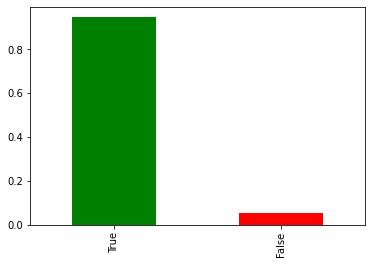

In [27]:
spacex_data['launch_success'].value_counts(normalize=True).plot(kind='bar', color=['g','r'])

In [28]:
spacex_year = spacex_data.groupby(['launch_year', 'launch_success']).agg({'flight_number':'count','rocket_second_stage_payloads_0_payload_mass_kg':'mean'}).reset_index()
spacex_year

,launch_year,launch_success,flight_number,rocket_second_stage_payloads_0_payload_mass_kg
0,2006,False,1,20.000000
1,2007,False,1,NaN
2,2008,False,1,NaN
3,2008,True,1,165.000000
4,2009,True,1,200.000000
5,2010,True,2,NaN
6,2012,True,2,462.500000
7,2013,True,3,1449.000000
8,2014,True,6,3019.333333
9,2015,False,1,2477.000000


In [29]:
launch_failure = pd.pivot_table(spacex_year, 
                                index='launch_year', 
                                columns='launch_success',
                               fill_value=0)
launch_failure

flight_number        \
launch_success         False True    
launch_year                          
2006                       1     0   
2007                       1     0   
2008                       1     1   
2009                       0     1   
2010                       0     2   
2012                       0     2   
2013                       0     3   
2014                       0     6   
2015                       1     6   
2016                       1     8   
2017                       0    18   
2018                       0    21   
2019                       0    13   
2020                       0     7   

               rocket_second_stage_payloads_0_payload_mass_kg                
launch_success                                          False         True   
launch_year                                                                  
2006                                                       20      0.000000  
2007                                                        0      0.000000  
2008                                                        0    165.000000  
2009                                                        0    200.000000  
2010                                                        0      0.000000  
2012                                                        0    462.500000  
2013                                                        0   1449.000000  
2014                                                        0   3019.333333  
2015                                                     2477   2259.666667  
2016                                                     5500   3176.625000  
2017                                                        0   5322.235294  
2018                                                        0   4394.242500  
2019                                                        0   6701.053846  
2020                                                        0  13229.500000

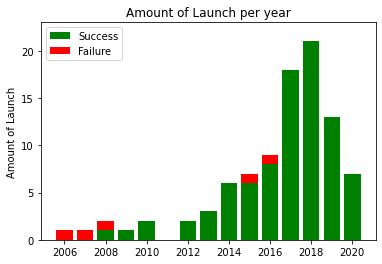

In [30]:
fig, ax = plt.subplots()
ax.bar(launch_failure.index,launch_failure['flight_number'][1], color='g',label='Success')
ax.bar(launch_failure.index,launch_failure['flight_number'][0], color='r', label='Failure',
       bottom=launch_failure['flight_number'][1])
ax.set_ylabel('Amount of Launch')
ax.set_title('Amount of Launch per year')
ax.set_ylim(top=23)
ax.legend()

plt.show()

In [31]:
rocket_type_groupby = spacex_data.groupby(['launch_year', 'rocket_rocket_type']).agg({'rocket_rocket_type':'count'})

rocket_type_groupby.rename(columns={'rocket_rocket_type':'amount'}, inplace=True)

rocket_type_groupby.reset_index()

,launch_year,rocket_rocket_type,amount
0,2006,Merlin A,1
1,2007,Merlin A,1
2,2008,Merlin C,2
3,2009,Merlin C,1
4,2010,v1.0,2
5,2012,v1.0,2
6,2013,v1.0,1
7,2013,v1.1,2
8,2014,v1.1,6
9,2015,FT,1


In [32]:
rocket_type_year = pd.pivot_table(data=rocket_type_groupby,
    index='launch_year', 
    columns='rocket_rocket_type',
    aggfunc='sum',
    fill_value=0)

rocket_type_year

amount                            
rocket_rocket_type     FT Merlin A Merlin C v1.0 v1.1
launch_year                                          
2006                    0        1        0    0    0
2007                    0        1        0    0    0
2008                    0        0        2    0    0
2009                    0        0        1    0    0
2010                    0        0        0    2    0
2012                    0        0        0    2    0
2013                    0        0        0    1    2
2014                    0        0        0    0    6
2015                    1        0        0    0    6
2016                    8        0        0    0    1
2017                   18        0        0    0    0
2018                   21        0        0    0    0
2019                   14        0        0    0    0
2020                   19        0        0    0    0

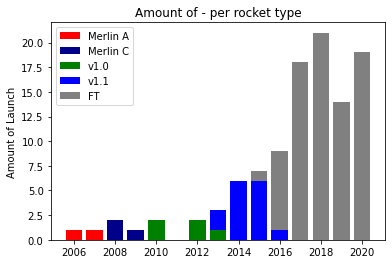

In [33]:
fig, ax = plt.subplots()
ax.bar(rocket_type_year.index,rocket_type_year['amount']['Merlin A'], color='r',label='Merlin A')
ax.bar(rocket_type_year.index,rocket_type_year['amount']['Merlin C'], color='darkblue',label='Merlin C',
              bottom=rocket_type_year['amount']['Merlin A'])
ax.bar(rocket_type_year.index,rocket_type_year['amount']['v1.0'], color='g',label='v1.0',
              bottom=rocket_type_year['amount']['Merlin C'])
ax.bar(rocket_type_year.index,rocket_type_year['amount']['v1.1'], color='b',label='v1.1',
              bottom=rocket_type_year['amount']['v1.0'])
ax.bar(rocket_type_year.index,rocket_type_year['amount']['FT'], color='gray', label='FT',
       bottom=rocket_type_year['amount']['v1.1'])
ax.set_ylabel('Amount of Launch')
ax.set_title('Amount of - per rocket type')
# ax.set_ylim(top=23)
ax.legend()

plt.show()

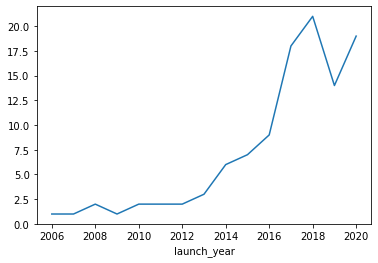

In [34]:
space_date = spacex_data.groupby('launch_year').agg({'flight_number':'count','rocket_second_stage_payloads_0_payload_mass_kg':'mean'})
space_date['flight_number'].plot()

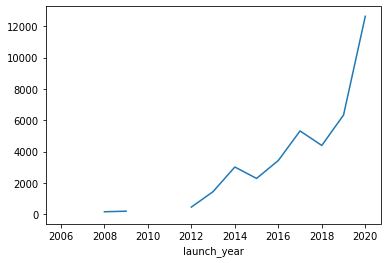

In [35]:
#evolution of mean payload per year
space_date['rocket_second_stage_payloads_0_payload_mass_kg'].plot()

In [36]:
# spacex_data['launch_date'] = pd.to_datetime(spacex_data['launch_date_local'], utc=False)
# # format='%Y-%m-%d')
# # # spacex_data['launch_date'].dt.strftime('%Y-%m-%d')
# # spacex_data['launch_date']

In [37]:
spacex_data['rocket_second_stage_payloads_0_payload_mass_kg'].describe()

count       92.000000
mean      5182.386413
std       4431.759760
min         20.000000
25%       2213.250000
50%       3940.000000
75%       6565.250000
max      15600.000000
Name: rocket_second_stage_payloads_0_payload_mass_kg, dtype: float64

In [38]:
spacex_data[spacex_data['rocket_second_stage_payloads_0_payload_mass_kg'] ==  15600]

,flight_number,mission_name,launch_year,launch_date_unix,launch_date_utc,launch_date_local,tentative_max_precision,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_landing_intent,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,rocket_second_stage_payloads_0_norad_id_0,launch_date,launch_time
83,84,Starlink 1,2019,1573484160,2019-11-11 09:56:00-05:00,2019-11-11T09:56:00-05:00,hour,0.0,falcon9,Falcon 9,FT,B1048,4.0,5.0,True,True,True,True,5.0,Starlink 1,False,SpaceX,United States,SpaceX,Satellite,15600.0,34392.100,VLEO,geocentric,very-low-earth,6927.873,0.000145,548.731,550.744,53.0001,95.644,2020-05-27T18:00:00.000Z,15.055766,307.4861,96.2487,79.6518,ccafs_slc_40,CCAFS SLC 40,Cape Canaveral Air Force Station Space Launch ...,True,This mission will launch the first batch of St...,2019-11-11T12:08:00.000Z,1.573474e+09,NaN,44713.0,2019-11-11,09:56:00
88,89,Starlink 3,2020,1580306760,2020-01-29 09:06:00-05:00,2020-01-29T09:06:00-05:00,hour,NaN,falcon9,Falcon 9,FT,B1051,3.0,5.0,True,True,True,True,5.0,Starlink 3,False,SpaceX,United States,SpaceX,Satellite,15600.0,34392.113,VLEO,geocentric,very-low-earth,6927.839,0.000198,548.332,551.077,52.9994,95.643,2020-05-27T20:00:01.000Z,15.055876,27.1080,81.6193,270.0790,ccafs_slc_40,CCAFS SLC 40,Cape Canaveral Air Force Station Space Launch ...,True,This mission will launch the third batch of St...,2020-01-20T13:17:00.000Z,1.579526e+09,NaN,45044.0,2020-01-29,09:06:00
91,92,Starlink 5,2020,1584533760,2020-03-18 08:16:00-04:00,2020-03-18T08:16:00-04:00,hour,0.0,falcon9,Falcon 9,FT,B1048,5.0,5.0,True,True,True,True,5.0,Starlink 5,False,SpaceX,United States,SpaceX,Satellite,15600.0,34392.113,VLEO,geocentric,very-low-earth,6927.918,0.000150,548.744,550.823,52.9998,95.645,2020-05-27T22:00:00.000Z,15.055618,166.7361,95.2603,117.4581,ksc_lc_39a,KSC LC 39A,Kennedy Space Center Historic Launch Complex 39A,True,The sixth Starlink launch overall and the fift...,2020-03-13T18:37:00.000Z,1.584125e+09,NaN,45178.0,2020-03-18,08:16:00


### API Call Launchpads geolocation

To plot geospatial datas from various launch sites, doing new API calls over launch site locations

In [39]:
# https://api.spacexdata.com/v3/launchpads/{{site_id}}

# for i in spacex_datea/launch_site_site_id

In [40]:
spacex_data['launch_site_site_id'].unique()

array(['kwajalein_atoll', 'ccafs_slc_40', 'vafb_slc_4e', 'ksc_lc_39a'],
      dtype=object)

In [41]:
spacex_data.launch_site_site_name_long.unique()

array(['Kwajalein Atoll Omelek Island',
       'Cape Canaveral Air Force Station Space Launch Complex 40',
       'Vandenberg Air Force Base Space Launch Complex 4E',
       'Kennedy Space Center Historic Launch Complex 39A'], dtype=object)

In [42]:
launch_responses_list = []

for i in spacex_data['launch_site_site_id'].unique():
    print('The rocket is on the launch pad - API call launchpad data')
    print(f'launchpad API call - requesting {i} data \n')
    
    response = requests.get(f'https://api.spacexdata.com/v3/launchpads/{i}')
    
    if response.status_code != 200:
        print('limit page result reached on page number',page,response.text, '- end of API call')
        break

    #if it's not a cached result, sleep
    if not getattr(response, 'from_cache', False):
        time.sleep(0.35)
    
    #append response list
    launch_responses_list.append(response)
    
print("SpaceX launchpad API call completed")

The rocket is on the launch pad - API call launchpad data
launchpad API call - requesting kwajalein_atoll data 

The rocket is on the launch pad - API call launchpad data
launchpad API call - requesting ccafs_slc_40 data 

The rocket is on the launch pad - API call launchpad data
launchpad API call - requesting vafb_slc_4e data 

The rocket is on the launch pad - API call launchpad data
launchpad API call - requesting ksc_lc_39a data 

SpaceX launchpad API call completed


Creating new dataframe of launc sites

In [45]:
#empty list to append all API calls
temp_launch_frame = [] 
for i in range(len(launch_responses_list)):
    r = launch_responses_list[i]    
    flat = flatten_json(r.json())
    temp_launch_frame.append(flat)
    flatten_launch_df = pd.DataFrame(temp_launch_frame)
flatten_launch_df

,id,name,status,location_name,location_region,location_latitude,location_longitude,vehicles_launched_0,attempted_launches,successful_launches,wikipedia,details,site_id,site_name_long,vehicles_launched_1
0,1,Kwajalein Atoll,retired,Omelek Island,Marshall Islands,9.047721,167.743129,Falcon 1,5,2,https://en.wikipedia.org/wiki/Omelek_Island,"SpaceX original launch site, where all of the ...",kwajalein_atoll,Kwajalein Atoll Omelek Island,NaN
1,2,CCAFS SLC 40,active,Cape Canaveral,Florida,28.561857,-80.577366,Falcon 9,52,50,https://en.wikipedia.org/wiki/Cape_Canaveral_A...,"SpaceX primary Falcon 9 launch pad, where all ...",ccafs_slc_40,Cape Canaveral Air Force Station Space Launch ...,NaN
2,6,VAFB SLC 4E,active,Vandenberg Air Force Base,California,34.632093,-120.610829,Falcon 9,15,15,https://en.wikipedia.org/wiki/Vandenberg_AFB_S...,SpaceX primary west coast launch pad for polar...,vafb_slc_4e,Vandenberg Air Force Base Space Launch Complex 4E,NaN
3,4,KSC LC 39A,active,Cape Canaveral,Florida,28.608058,-80.603956,Falcon 9,21,21,https://en.wikipedia.org/wiki/Kennedy_Space_Ce...,NASA historic launch pad that launched most of...,ksc_lc_39a,Kennedy Space Center Historic Launch Complex 39A,Falcon Heavy


In [47]:
flatten_launch_df[['site_id' ,'location_latitude', 'location_longitude']]

,site_id,location_latitude,location_longitude
0,kwajalein_atoll,9.047721,167.743129
1,ccafs_slc_40,28.561857,-80.577366
2,vafb_slc_4e,34.632093,-120.610829
3,ksc_lc_39a,28.608058,-80.603956


Creating Point from each longitude & latitude locations - to then inject them in an ad hoc Geo df

In [86]:
geometry = [Point(xy) for xy in zip(flatten_launch_df['location_longitude'], flatten_launch_df['location_latitude'])]

In [87]:
geometry

In [88]:
crs = {'init':'epsg:4326'}

In [89]:
geo_df = gpd.GeoDataFrame(flatten_launch_df,
                         crs = crs,
                         geometry = geometry)

geo_df.head()

,id,name,status,location_name,location_region,location_latitude,location_longitude,vehicles_launched_0,attempted_launches,successful_launches,wikipedia,details,site_id,site_name_long,vehicles_launched_1,geometry
0,1,Kwajalein Atoll,retired,Omelek Island,Marshall Islands,9.047721,167.743129,Falcon 1,5,2,https://en.wikipedia.org/wiki/Omelek_Island,"SpaceX original launch site, where all of the ...",kwajalein_atoll,Kwajalein Atoll Omelek Island,NaN,POINT (167.74313 9.04772)
1,2,CCAFS SLC 40,active,Cape Canaveral,Florida,28.561857,-80.577366,Falcon 9,52,50,https://en.wikipedia.org/wiki/Cape_Canaveral_A...,"SpaceX primary Falcon 9 launch pad, where all ...",ccafs_slc_40,Cape Canaveral Air Force Station Space Launch ...,NaN,POINT (-80.57737 28.56186)
2,6,VAFB SLC 4E,active,Vandenberg Air Force Base,California,34.632093,-120.610829,Falcon 9,15,15,https://en.wikipedia.org/wiki/Vandenberg_AFB_S...,SpaceX primary west coast launch pad for polar...,vafb_slc_4e,Vandenberg Air Force Base Space Launch Complex 4E,NaN,POINT (-120.61083 34.63209)
3,4,KSC LC 39A,active,Cape Canaveral,Florida,28.608058,-80.603956,Falcon 9,21,21,https://en.wikipedia.org/wiki/Kennedy_Space_Ce...,NASA historic launch pad that launched most of...,ksc_lc_39a,Kennedy Space Center Historic Launch Complex 39A,Falcon Heavy,POINT (-80.60396 28.60806)


In [99]:
#importing world map to plot launch sites
wm = gpd.read_file(r'http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip')

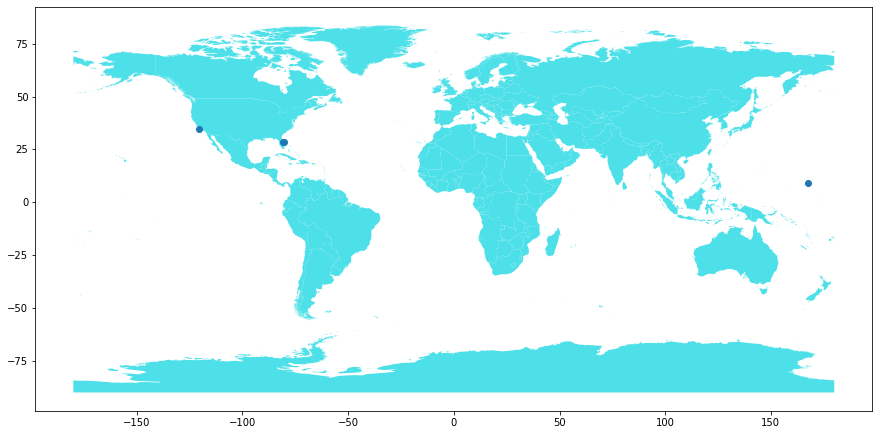

In [98]:
fig, ax = plt.subplots(figsize=(15,15))
wm.plot(ax = ax, color='#4DE0E8')
geo_df['geometry'].plot(ax=ax)

In [ ]:
#Test - importing only US map

In [90]:
us_map = gpd.read_file(r'https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip')

In [91]:
us_map

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266231560,489271086,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138947364717,31362872853,+28.4574302,-082.4091477,"MULTIPOLYGON (((-86.38865 30.99418, -86.38385 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143779863817,6215723896,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206230065476,18942261495,+46.3159573,-094.1996043,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151726296,6979340970,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."
5,1,1,44,01219835,44,RI,Rhode Island,00,G4000,A,2677787140,1323663210,+41.5974187,-071.5272723,"MULTIPOLYGON (((-71.78970 41.72520, -71.78971 ..."
6,4,8,16,01779783,16,ID,Idaho,00,G4000,A,214049897859,2391604238,+44.3484222,-114.5588538,"POLYGON ((-116.89971 44.84061, -116.89967 44.8..."
7,1,1,33,01779794,33,NH,New Hampshire,00,G4000,A,23189198255,1026903434,+43.6726907,-071.5843145,"POLYGON ((-72.32990 43.60021, -72.32984 43.600..."
8,3,5,37,01027616,37,NC,North Carolina,00,G4000,A,125925929633,13463401534,+35.5397100,-079.1308636,"POLYGON ((-82.41674 36.07283, -82.41660 36.073..."
9,1,1,50,01779802,50,VT,Vermont,00,G4000,A,23874197924,1030383955,+44.0685773,-072.6691839,"POLYGON ((-73.31328 44.26413, -73.31274 44.265..."


In [92]:
#droping US oversea territories to keep only continental US 
us_continent = us_map.drop([31,34,35,36,40,41,49])

In [49]:
merged_json = flatten_launch_df[['id','site_id' ,'location_latitude', 'location_longitude']].to_json()

In [50]:
merged_json

'{"id":{"0":1,"1":2,"2":6,"3":4},"site_id":{"0":"kwajalein_atoll","1":"ccafs_slc_40","2":"vafb_slc_4e","3":"ksc_lc_39a"},"location_latitude":{"0":9.0477206,"1":28.5618571,"2":34.632093,"3":28.6080585},"location_longitude":{"0":167.7431292,"1":-80.577366,"2":-120.610829,"3":-80.6039558}}'

In [51]:
# fig = px.choropleth(data_frame=happiness,
#              geojson=merged_json,
#               color='happiness-score',
#               locations='Country',
#               featureidkey="properties.CNTRY_NAME", #location feature's name in the geojson
#               projection='orthographic')

# # fig.update_geos(fitbounds="locations", visible=True)
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

In [52]:
px.choropleth(flatten_launch_df,
             lat='location_latitude',
             lon='location_longitude')

# fig.update_geos(fitbounds="locations", visible=True)
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

ValueError: Invalid properties specified for object of type plotly.graph_objs.Choropleth: ('lat', 'lon')

    Valid properties:
        autocolorscale
            Determines whether the colorscale is a default palette
            (`autocolorscale: true`) or the palette determined by
            `colorscale`. In case `colorscale` is unspecified or
            `autocolorscale` is true, the default  palette will be
            chosen according to whether numbers in the `color`
            array are all positive, all negative or mixed.
        coloraxis
            Sets a reference to a shared color axis. References to
            these shared color axes are "coloraxis", "coloraxis2",
            "coloraxis3", etc. Settings for these shared color axes
            are set in the layout, under `layout.coloraxis`,
            `layout.coloraxis2`, etc. Note that multiple color
            scales can be linked to the same color axis.
        colorbar
            :class:`plotly.graph_objects.choropleth.ColorBar`
            instance or dict with compatible properties
        colorscale
            Sets the colorscale. The colorscale must be an array
            containing arrays mapping a normalized value to an rgb,
            rgba, hex, hsl, hsv, or named color string. At minimum,
            a mapping for the lowest (0) and highest (1) values are
            required. For example, `[[0, 'rgb(0,0,255)'], [1,
            'rgb(255,0,0)']]`. To control the bounds of the
            colorscale in color space, use`zmin` and `zmax`.
            Alternatively, `colorscale` may be a palette name
            string of the following list: Greys,YlGnBu,Greens,YlOrR
            d,Bluered,RdBu,Reds,Blues,Picnic,Rainbow,Portland,Jet,H
            ot,Blackbody,Earth,Electric,Viridis,Cividis.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            customdata .
        featureidkey
            Sets the key in GeoJSON features which is used as id to
            match the items included in the `locations` array. Only
            has an effect when `geojson` is set. Support nested
            property, for example "properties.name".
        geo
            Sets a reference between this trace's geospatial
            coordinates and a geographic map. If "geo" (the default
            value), the geospatial coordinates refer to
            `layout.geo`. If "geo2", the geospatial coordinates
            refer to `layout.geo2`, and so on.
        geojson
            Sets optional GeoJSON data associated with this trace.
            If not given, the features on the base map are used. It
            can be set as a valid GeoJSON object or as a URL
            string. Note that we only accept GeoJSONs of type
            "FeatureCollection" or "Feature" with geometries of
            type "Polygon" or "MultiPolygon".
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            hoverinfo .
        hoverlabel
            :class:`plotly.graph_objects.choropleth.Hoverlabel`
            instance or dict with compatible properties
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}". https://github.com/d3/d3-3.x-api-
            reference/blob/master/Formatting.md#d3_format for
            details on the formatting syntax. Dates are formatted
            using d3-time-format's syntax %{variable|d3-time-
            format}, for example "Day: %{2019-01-01|%A}".
            https://github.com/d3/d3-3.x-api-
            reference/blob/master/Time-Formatting.md#format for
            details on the date formatting syntax. The variables
            available in `hovertemplate` are the ones emitted as
            event data described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            hovertemplate .
        hovertext
            Same as `text`.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            hovertext .
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            ids .
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        locationmode
            Determines the set of locations used to match entries
            in `locations` to regions on the map. Values "ISO-3",
            "USA-states", *country names* correspond to features on
            the base map and value "geojson-id" corresponds to
            features from a custom GeoJSON linked to the `geojson`
            attribute.
        locations
            Sets the coordinates via location IDs or names. See
            `locationmode` for more info.
        locationssrc
            Sets the source reference on Chart Studio Cloud for
            locations .
        marker
            :class:`plotly.graph_objects.choropleth.Marker`
            instance or dict with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            meta .
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        reversescale
            Reverses the color mapping if true. If true, `zmin`
            will correspond to the last color in the array and
            `zmax` will correspond to the first color.
        selected
            :class:`plotly.graph_objects.choropleth.Selected`
            instance or dict with compatible properties
        selectedpoints
            Array containing integer indices of selected points.
            Has an effect only for traces that support selections.
            Note that an empty array means an empty selection where
            the `unselected` are turned on for all points, whereas,
            any other non-array values means no selection all where
            the `selected` and `unselected` styles have no effect.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        showscale
            Determines whether or not a colorbar is displayed for
            this trace.
        stream
            :class:`plotly.graph_objects.choropleth.Stream`
            instance or dict with compatible properties
        text
            Sets the text elements associated with each location.
        textsrc
            Sets the source reference on Chart Studio Cloud for
            text .
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        unselected
            :class:`plotly.graph_objects.choropleth.Unselected`
            instance or dict with compatible properties
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        z
            Sets the color values.
        zauto
            Determines whether or not the color domain is computed
            with respect to the input data (here in `z`) or the
            bounds set in `zmin` and `zmax`  Defaults to `false`
            when `zmin` and `zmax` are set by the user.
        zmax
            Sets the upper bound of the color domain. Value should
            have the same units as in `z` and if set, `zmin` must
            be set as well.
        zmid
            Sets the mid-point of the color domain by scaling
            `zmin` and/or `zmax` to be equidistant to this point.
            Value should have the same units as in `z`. Has no
            effect when `zauto` is `false`.
        zmin
            Sets the lower bound of the color domain. Value should
            have the same units as in `z` and if set, `zmax` must
            be set as well.
        zsrc
            Sets the source reference on Chart Studio Cloud for  z
            .
        

In [ ]:
px.choropleth(spacex_data,
             geojson=merged_json,
             locations='launch_site_site_id',
             featureidkey='properties.site_id')

In [ ]:
# spacex_data['launch_date'] = spacex_data['launch_date_local'].astype('datetime64[D]')

### OLD

### for loop to create final df with all calls from appended list

In [ ]:
#empty list to append all API calls
frame = [] 
for i in range(len(responses_list)):
    r = responses_list[i]
    df_temp = pd.DataFrame(json_normalize(r.json()))
    frame.append(df_temp)
df_launch_raw = pd.concat(frame, sort=False)

In [ ]:
r.json()

In [ ]:
print(len(responses_list))

type(responses_list[0])

In [ ]:
df_launch_raw

In [ ]:
df_launch_raw.to_csv('launch_raw.csv', index=False)

### Series of columns to keep

In [ ]:
## dropping links columns

In [ ]:
links = ['links.mission_patch',
       'links.mission_patch_small', 'links.reddit_campaign',
       'links.reddit_launch', 'links.reddit_recovery', 'links.reddit_media',
       'links.presskit', 'links.article_link', 'links.wikipedia',
       'links.video_link', 'links.youtube_id', 'links.flickr_images']

In [ ]:
# df_launch_raw.drop(columns=links, inplace=True)
# df_launch_raw

In [ ]:
Rocket_related = pd.Series(
['rocket_id',
'rocket_name',
'rocket_type',
'second_stage.payloads',
'fairings.reused',
'fairings.recovery_attempt',
'fairings.recovered'])

In [ ]:
rocket = pd.DataFrame(Rocket_related)
rocket

In [ ]:
percent_missing = df_launch_raw.isnull().sum() / len(df_launch_raw) * 100

percent_missing.tail(10)

In [ ]:
missing_value = pd.DataFrame({'column_name': df_launch_raw.columns,
                             'percent_missing':percent_missing})

#filtering to display only columns with 0% missing data = 100% complete columns
missing_value.sort_values(by='percent_missing').head(50)

In [ ]:
kept_columns = missing_value.sort_values(by='percent_missing').head(50).index

kept_columns

In [ ]:
#ditching columns with over 50% null values

In [ ]:
ditch_columns = missing_value[missing_value['percent_missing'] > 50]

ditch_columns

In [ ]:
df_launch_fs = df_launch_raw.drop(columns=ditch_columns.index)

df_launch_fs

In [ ]:
df_launch_fs.info()

In [ ]:
# data conversion
df_launch_fs['launch_success'] = df_launch_fs['launch_success'].astype(bool)
df_launch_fs['launch_date_utc'] = pd.to_datetime(df_launch_fs['launch_date_utc'])

In [ ]:
df_launch_fs['launch_date_utc']

In [ ]:
df_launch_fs['launch_success'].value_counts(normalize=True).plot(kind='bar', color=['g','r'])

In [ ]:
df_launch_fs['launch_date_utc']

In [ ]:
df_launch_fs['launch_date_utc']

In [ ]:
df_launch_group = df_launch_fs.groupby('launch_date_utc').agg('count')

df_launch_group

In [ ]:
df_launch_group['flight_number'].plot()

In [ ]:
df_launch_fs['launch_date_utc'].plot()

In [ ]:
# for column in df_launch_fs.select_dtypes('object'):
# #     print(f'{column:-<70} {df_launch_fs[column].unique()}')

In [ ]:
Launch_related = pd.Series(
['launch_year', 
'launch_date_unix', 
'launch_date_utc',
'crew', 
'ships', 
'launch_success',
'details', 
'launch_site.site_id', 
'launch_site.site_name', 
'launch_site.site_name_long', 
'launch_failure_details.time', 
'launch_failure_details.altitude', 
'launch_failure_details.reason'])

launch = pd.DataFrame(Launch_related)
launch

In [ ]:
spacex_data

In [ ]:
spacex_data['launch_date_utc'].asfreq(freq='m')

In [ ]:
seasonality = sm.tsa.seasonal_decompose(spacex_data['launch_date_utc'], period=50)

seasonality.plot()

In [ ]:
# space2 = spacex_data.set_index('launch_date_local')

In [ ]:
# seasonality = sm.tsa.seasonal_decompose(space2.index, freq=None)

# seasonality.plot()

In [ ]:
space2.index